In [166]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Dense, Input, Flatten, Lambda
from keras.losses import binary_crossentropy, MeanSquaredError
from keras import Model
from keras import backend as K
import numpy as np
from tqdm import tqdm
print(f"Using Tensorflow v{tf.__version__}")

Using Tensorflow v2.11.0


In [2]:
def normalize(tensor):
    tensor_minusmin = tensor - tensor.min()
    tensor_maxminusmin = tensor.max() - tensor.min()
    return tensor_minusmin / tensor_maxminusmin

def get_waves(file_name):
    # Read the raw audio from the .WAV file
    raw_audio = tf.io.read_file(filename=file_name)
    # Convert the raw audio to a waveform
    wave_bank, sample_rate = tf.audio.decode_wav(raw_audio)
    # Display the wavebank and sample_rate
    # display(wave_bank, sample_rate)
    wave_size = 256
    num_waves = 0
    waves = []
    wave_forms = np.transpose(wave_bank.numpy())
    for i in range(64):
        wave_form = wave_forms[0, i*wave_size:i*wave_size+wave_size]
        if wave_form.max() != wave_form.min():
            wave_form = normalize(wave_form)
            waves.append(wave_form)
            num_waves += 1    
    waves = tf.stack(waves)
    return waves

In [18]:
enc_input_shape = (256,1,1)
latent_dim = 16
encoder = Sequential([
    Input(enc_input_shape, name="encoder_input"),
    Conv2D(filters=16, kernel_size=(4,1), 
           strides=(2,1), padding="same",
           activation="relu", name="conv2d_1"
    ),
    Conv2D(filters=32, kernel_size=(4,1),
           strides=(2,1), padding="same",
           activation="relu", name="conv2d_2"
    ),
    Reshape((1,-1), name="reshape"),
    Dense(latent_dim+latent_dim, name="mu")
], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 1, 16)        80        
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 1, 32)         2080      
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 mu (Dense)                  (None, 1, 32)             65568     
                                                                 
Total params: 67,728
Trainable params: 67,728
Non-trainable params: 0
_________________________________________________________________


In [211]:
enc_input_shape = (1,256,1,1)
latent_dim = 16

class Encoder(Model):
    name="encoder"
    def __init__(self):
        super().__init__()
        self.training = True
        self.conv1 = Conv2D(filters=16, kernel_size=(4,1), 
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_1")
        self.conv2 = Conv2D(filters=32, kernel_size=(4,1),
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_2"
                            )
        self.flatten = Reshape((1,-1), name="flatten")
        self.mu = Dense(latent_dim, name="mu")
        self.log_var = Dense(latent_dim, name="log_var")
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        temp = self.flatten(x)
        mu = self.mu(temp)
        log_var = self.log_var(temp)
        if self.training:
            return [mu,log_var]
        else:
            return mu
    
    def eval():
        training = False     

In [216]:
dec_input_shape = (1,1,16,1)
latent_dim = 16

class Decoder(Model):
    name="decoder"
    def __init__(self):
        super().__init__()
        
        self.training = True
        self.dense = Dense(128, name='decoder_dense_1')
        self.reshape = Reshape((1,64,-1), name="decoder_reshape")
        self.conv1T = Conv2DTranspose(filters=16, kernel_size=(1,4),
                                      strides=(1,2), padding="same",
                                      activation="relu", name="conv2dT_1")
        self.conv2T = Conv2DTranspose(filters=1, kernel_size=(1,4), 
                                      strides=(1,2), padding="same",
                                      activation="sigmoid", name="decoder_output")
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1T(x)
        x = self.conv2T(x)
        return x
    
    def eval():
        training = False        

In [217]:
class VAE(Model):
    name = "vae"
    def __init__(self):
        super().__init__()
        self.training = True
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = tf.expand_dims(x, -1)
        return self.decoder(x[0])

In [218]:
waves = get_waves("./audio_data/ENVELO01.WAV")
waves = tf.expand_dims(waves, 1)
waves = tf.expand_dims(waves, -1)
waves = tf.expand_dims(waves, -1)
display(waves[0].shape)

TensorShape([1, 256, 1, 1])

In [219]:
vae = VAE()
vae.encoder.build(enc_input_shape)
vae.decoder.build(dec_input_shape)
vae.build(enc_input_shape)
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  67728     
                                                                 
 decoder (Decoder)           multiple                  2385      
                                                                 
Total params: 70,113
Trainable params: 70,113
Non-trainable params: 0
_________________________________________________________________


In [220]:
vae.compile(optimizer='adam', loss=binary_crossentropy)


In [221]:
a = vae(waves[0])

In [222]:
a.shape

TensorShape([1, 1, 256, 1])

In [223]:
waves[0].shape

TensorShape([1, 256, 1, 1])

In [235]:
vae.fit(waves, waves,
                epochs=2000,
                shuffle=True,
                validation_data=(waves, waves))

Epoch 1/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 2/2000
2/2 [==============================] - 0s 19ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 3/2000
2/2 [==============================] - 0s 21ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 4/2000
2/2 [==============================] - 0s 23ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 5/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 6/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 7/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 8/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 9/2000
2/2 [==============================] - 0s 18ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 10/2000
2/2 [==============================] - 0s 17ms/step - loss: 0.2298 - val_loss: 0.2298
Epoch 11/

TensorShape([1, 1, 256, 1])

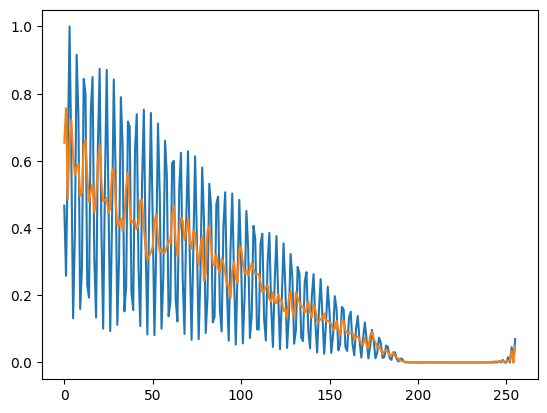

In [236]:
import matplotlib.pyplot as plt
plt.plot(tf.squeeze(waves[0]))
decoded = vae(waves[0])
display(decoded.shape)
plt.plot(tf.squeeze(decoded))